In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# from google.colab import drive
# drive.mount('/content/drive')

#LOADING THE DATA TABLES


In [91]:
raw_data = pd.read_csv("fakenews_data.csv")

In [92]:
raw_data

,Polarity,Text
0,Fake,Universities Agree with Trump on Immigration\n...
1,Fake,Chris Pratt responds to body shamers telling h...
2,Fake,"""Dancing With the Stars"": First couple won the..."
3,Fake,Brian Cox hosts scientist Postman Pat\n\nProfe...
4,Fake,London Stock Exchange has dropped Merger with ...
...,...,...
475,TRUE,Jason Witten signs new four-year deal with Dal...
476,TRUE,Google Maps can tell your friends exactly wher...
477,TRUE,Let there be light: German scientists test 'ar...
478,TRUE,Roger Federer beats Frances Tiafoe on return ...


load the three_final_features.csv

In [93]:
final_fts = pd.read_csv("three_final_features.csv")


In [94]:
final_fts.shape #indexes are split and start from 0, change from polarity at 239

(480, 4)

In [95]:
final_fts

,DESPLd,DESWLltd,WORD_PROPERTY_WRDHYPn,Polarity
0,0.000000,0.998218,0.244583,0
1,0.272727,0.221451,0.267995,0
2,0.363636,0.198063,0.471208,0
3,0.272727,0.212835,0.467174,0
4,0.454545,0.225762,0.622575,0
...,...,...,...,...
475,0.176471,0.062359,0.506349,1
476,0.037203,0.000000,0.455246,1
477,0.048029,0.095503,0.592211,1
478,0.352941,0.066419,0.492107,1


# MODEL CREATION FUNCTIONS

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn import model_selection

import pickle


def data_preprocess(data):
  '''We input the data with the linguistic features
  And it returns the data with the polarity columns in 0 for fake and 1 for true
  as well as the outcomes
  '''

  if data.Polarity[0] != 0 or 1:
    data.Polarity[data.Polarity == 'Fake'] = 0
    data.Polarity[data.Polarity == 'TRUE'] = 1

  outcomes = ["Fake","Real"]
  # print("unique Polairty labels:", data.Polarity.unique())

  return data, outcomes


def test_train(data, features):

  '''We input the data with the features and a list of the features we want to pass to the models.
  it returns the data split in test/train
  '''

  data = data.dropna()
  feature_cols = features



  X = data[feature_cols]
  y = data.Polarity #outcomes 0 or 1

  print("Info: {} features were passed at the fit step\n:".format(X.shape[1]))
  for feature in feature_cols:
    print(feature)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=16)

  return X, y, X_train, X_test, y_train, y_test, features

  #stratify so that the proportion of the train data is the same for fake and true


def class_report(y_test, y_pred):

  scores = classification_report(y_test, y_pred, target_names=outcomes)

  print(scores)

  return scores

def compare_models_cross_val(model, X, y):
  '''for each model, it calculates the cross validation accuracy for each iteration
  as well as the mean cross validation score on the given data

  '''

  print("CROSS VALIDATION\n")

  model_name = str(model)[:-2]

  if model_name == "SVC(kernel=\'linear":

    model_name = "SVC"


  # for model in models:
  cv_score = cross_val_score(model, X, y, cv = 5)
  print("Accuracy {} for each of the 5 iterations:".format(model_name))
  for score in cv_score:
    print(round(score*100, 2), "%")

  mean_accuracy = sum(cv_score)/len(cv_score)

  print("\nCross validation mean accuracy for {}:".format(model_name), round(mean_accuracy*100, 2),"%")
  print("\n-------------------------------------------------------------------------\n")

  return cv_score, mean_accuracy

def conf_matrix(model_name, features, y_pred, y_test, outcomes =outcomes, cmap="magma"):

  '''This function takes the predicted and test labels, generates the confusion matrix
  and displays it
  '''

  n_features = len(features)

  confussion_matrix = confusion_matrix(y_pred, y_test)

  outcomes = ["Fake","Real"]
  ticks = np.arange(len(outcomes))

  fig, ax = plt.subplots()
  plt.xticks(ticks, outcomes)
  plt.yticks(ticks, outcomes)
  sns.heatmap(pd.DataFrame(confussion_matrix), annot=True, cmap=cmap, fmt="g", xticklabels=outcomes, yticklabels=outcomes)
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  if n_features == 1:

    plt.title("{} Confusion Matrix: {}".format(model_name, features[0]), y = 1.1)

  elif n_features == 2:

    plt.title("{} Confusion Matrix: {} and {}".format(model_name, features[0],features[1]), y = 1.1)

  elif n_features == 3:

    plt.title("{} Confusion Matrix: {}, {} and {}".format(model_name, features[0],features[1], features[2]), y = 1.1)

  plt.ylabel("Actual label")
  plt.xlabel("Predicted label")

  return confussion_matrix

def compare_models_train_test_split(models, X, y, X_train, y_train, X_test, y_test, features):

  '''this fx trains the data on the four types of models,
  generates a report with the overall accuracy of the model, the cross validation evaluation
  and prints the confussion matrix of each model on the particular test_train split.

  It returns a dictionary with the name of the model, the features that were passed during the fit,
  the model used, the accuracy score, the classification report, the crossvalidation evaluation and the confusion matrix
  '''

  model_list_dicts =[]

  for model in models:

    model_name = str(model)[:-2]

    if model_name == "SVC(kernel=\'linear":

      model_name = "SVC"

    model_dict = {}

    ft_str = str(features)[2:-2].replace("'","_").replace(",", "_").replace(" ", "_").replace("___", "_")

    model_dict["name"] = ft_str + "__" + model_name

    model_dict["features"] = features

    model_dict["model"] = model_name

    print("\n",model_name, "\n", "\n")

    model = model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    model_dict["accuracy"] = accuracy

    print("OVERALL ACCURACY", model_name, ":", round(accuracy*100, 2),"%""\n")


    scores = class_report(y_test, y_pred)

    model_dict["report"] = scores

    # print(scores)

    print("\n")

    cv_score, mean_accuracy = compare_models_cross_val(model, X, y)

    model_dict["cv_scores"] = cv_score

    model_dict["mean_cv_accuracy"] = mean_accuracy

    print("\n")

    confussion_matrix = conf_matrix(model_name, features, y_pred, y_test, cmap="magma")

    model_dict["confussion_matrix"] = confussion_matrix

    model_list_dicts.append(model_dict)

  return model_list_dicts

def magic(data, features):

  '''this function takes all the previous functions and integrates them into a single function to run the data processing, training and testing in all the models.

  It returns a dictionary with the name of the model, the features that were passed during the fit,
  the model used, the accuracy score, the classification report, the crossvalidation evaluation and the confusion matrix

  '''

  data, outcomes = data_preprocess(data) # data in the correct format for the y outcomes

  X, y, X_train, X_test, y_train, y_test, features = test_train(data, features) # here we have the data split for all the models with the desired features

  model_list_dicts = compare_models_train_test_split(models, X, y, X_train, y_train, X_test, y_test, features) # for each model it will compute

  return model_list_dicts


In [97]:
models = [LogisticRegression(), SVC(kernel ="linear"), KNeighborsClassifier(), RandomForestClassifier()]


NOW FOR EVERY LIST OF FEATURES, WE ARE GOING TO HAVE 4 MODELS

# Logistic Regression using all the 3 features

---



<ipython-input-96-eb9d9cbc9add>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Polarity[data.Polarity == 'Fake'] = 0
<ipython-input-96-eb9d9cbc9add>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Polarity[data.Polarity == 'TRUE'] = 1


Info: 3 features were passed at the fit step
:
DESPLd
DESWLltd
WORD_PROPERTY_WRDHYPn

 LogisticRegression 
 

OVERALL ACCURACY LogisticRegression : 97.35 %

              precision    recall  f1-score   support

        Fake       1.00      0.94      0.97        53
        Real       0.95      1.00      0.98        60

    accuracy                           0.97       113
   macro avg       0.98      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113



CROSS VALIDATION

Accuracy LogisticRegression for each of the 5 iterations:
92.22 %
90.0 %
96.67 %
91.11 %
94.44 %

Cross validation mean accuracy for LogisticRegression: 92.89 %

-------------------------------------------------------------------------




 SVC 
 

OVERALL ACCURACY SVC : 96.46 %

              precision    recall  f1-score   support

        Fake       1.00      0.92      0.96        53
        Real       0.94      1.00      0.97        60

    accuracy                           0.96       1

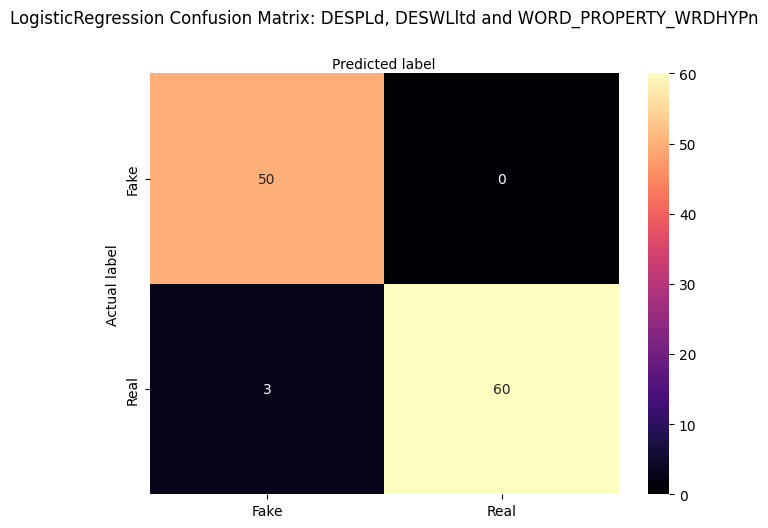

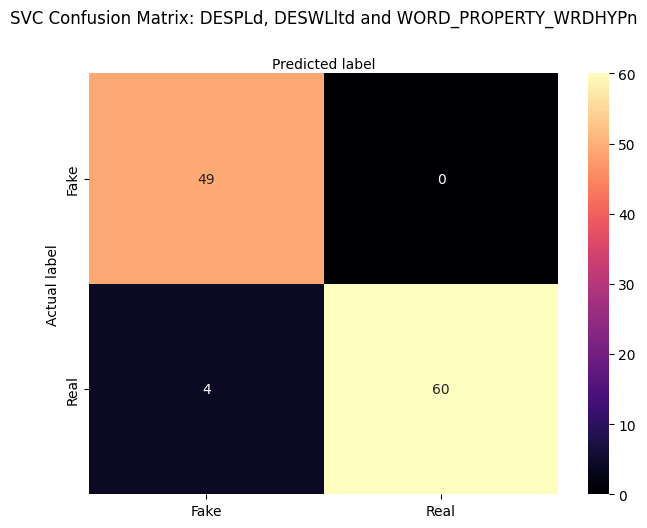

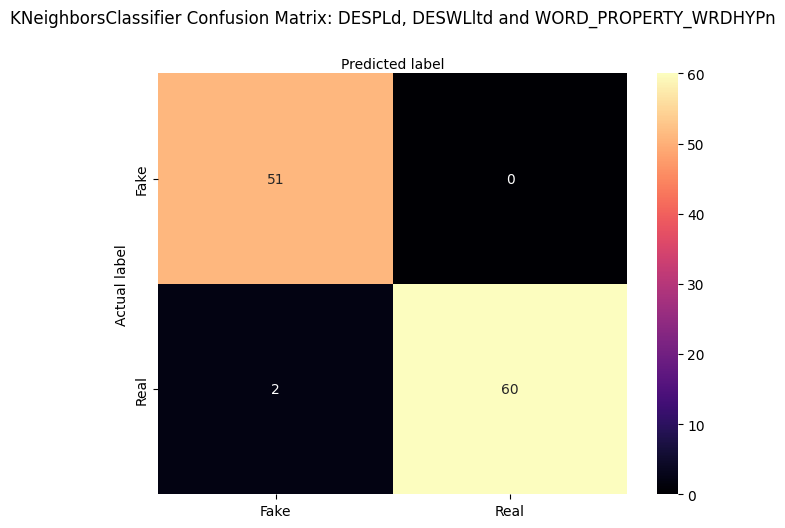

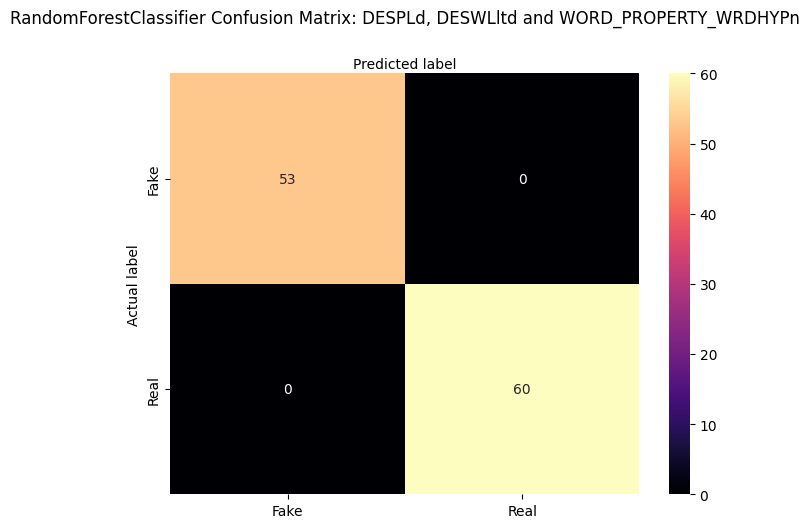

In [99]:
features = ['DESPLd',	'DESWLltd',	'WORD_PROPERTY_WRDHYPn']


models_all_features = magic(final_fts, features)

In [100]:
models_all_features

[{'name': 'DESPLd__DESWLltd__WORD_PROPERTY_WRDHYPn__LogisticRegression',
  'features': ['DESPLd', 'DESWLltd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'LogisticRegression',
  'accuracy': 0.9734513274336283,
  'report': '              precision    recall  f1-score   support\n\n        Fake       1.00      0.94      0.97        53\n        Real       0.95      1.00      0.98        60\n\n    accuracy                           0.97       113\n   macro avg       0.98      0.97      0.97       113\nweighted avg       0.97      0.97      0.97       113\n',
  'cv_score': array([0.92222222, 0.9       , 0.96666667, 0.91111111, 0.94444444]),
  'mean_cv_accuracy': 0.928888888888889,
  'confussion_matrix': array([[50,  0],
         [ 3, 60]])},
 {'name': 'DESPLd__DESWLltd__WORD_PROPERTY_WRDHYPn__SVC',
  'features': ['DESPLd', 'DESWLltd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'SVC',
  'accuracy': 0.9646017699115044,
  'report': '              precision    recall  f1-score   support\n\n        Fake      

# Logistic Regression excluding different features each time

DESWLltd and WORD_PROPERTY_WRDHYPn

<ipython-input-96-eb9d9cbc9add>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Polarity[data.Polarity == 'Fake'] = 0
<ipython-input-96-eb9d9cbc9add>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Polarity[data.Polarity == 'TRUE'] = 1


Info: 2 features were passed at the fit step
:
DESWLltd
WORD_PROPERTY_WRDHYPn

 LogisticRegression 
 

OVERALL ACCURACY LogisticRegression : 97.35 %

              precision    recall  f1-score   support

        Fake       1.00      0.94      0.97        53
        Real       0.95      1.00      0.98        60

    accuracy                           0.97       113
   macro avg       0.98      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113



CROSS VALIDATION

Accuracy LogisticRegression for each of the 5 iterations:
91.11 %
88.89 %
95.56 %
92.22 %
94.44 %

Cross validation mean accuracy for LogisticRegression: 92.44 %

-------------------------------------------------------------------------




 SVC 
 

OVERALL ACCURACY SVC : 98.23 %

              precision    recall  f1-score   support

        Fake       1.00      0.96      0.98        53
        Real       0.97      1.00      0.98        60

    accuracy                           0.98       113
   

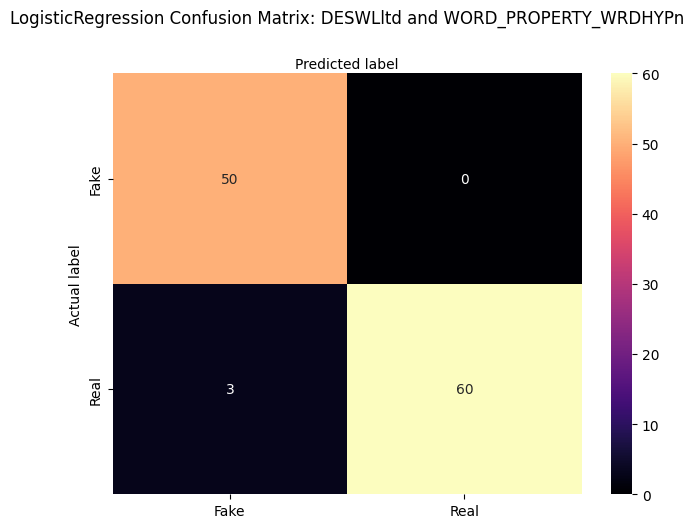

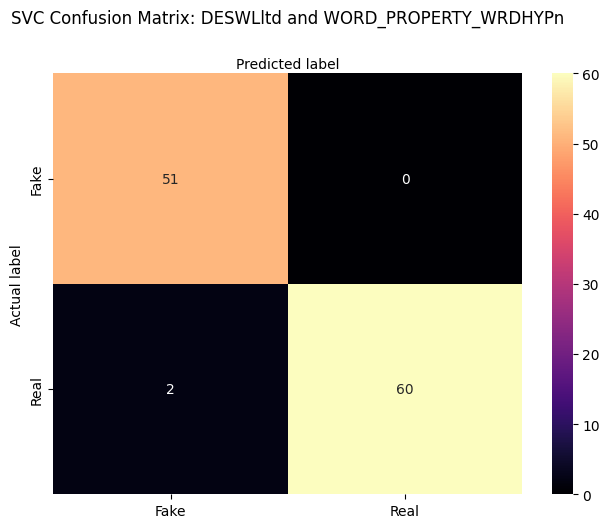

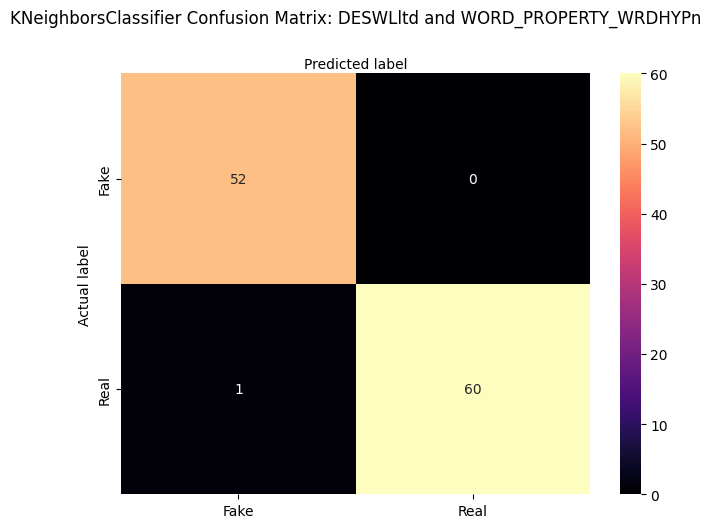

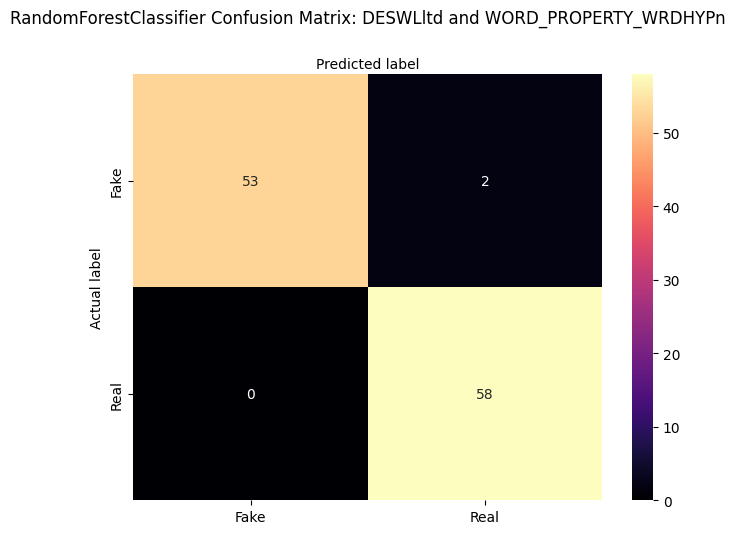

In [101]:
features = ['DESWLltd',	'WORD_PROPERTY_WRDHYPn']
models_DESWLltd_WORD_PROPERTY_WRDHYPn = magic(final_fts, features)

In [102]:
models_DESWLltd_WORD_PROPERTY_WRDHYPn

[{'name': 'DESWLltd__WORD_PROPERTY_WRDHYPn__LogisticRegression',
  'features': ['DESWLltd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'LogisticRegression',
  'accuracy': 0.9734513274336283,
  'report': '              precision    recall  f1-score   support\n\n        Fake       1.00      0.94      0.97        53\n        Real       0.95      1.00      0.98        60\n\n    accuracy                           0.97       113\n   macro avg       0.98      0.97      0.97       113\nweighted avg       0.97      0.97      0.97       113\n',
  'cv_score': array([0.91111111, 0.88888889, 0.95555556, 0.92222222, 0.94444444]),
  'mean_cv_accuracy': 0.9244444444444445,
  'confussion_matrix': array([[50,  0],
         [ 3, 60]])},
 {'name': 'DESWLltd__WORD_PROPERTY_WRDHYPn__SVC',
  'features': ['DESWLltd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'SVC',
  'accuracy': 0.9823008849557522,
  'report': '              precision    recall  f1-score   support\n\n        Fake       1.00      0.96      0.98        53

In [103]:
# pickle.dump(logistic_regression, open("lg_DESWLltd_WORD_PROPERTY_WRDHYPn", "wb"))

DESPLd and	WORD_PROPERTY_WRDHYPn

<ipython-input-96-eb9d9cbc9add>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Polarity[data.Polarity == 'Fake'] = 0
<ipython-input-96-eb9d9cbc9add>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Polarity[data.Polarity == 'TRUE'] = 1


Info: 2 features were passed at the fit step
:
DESPLd
WORD_PROPERTY_WRDHYPn

 LogisticRegression 
 

OVERALL ACCURACY LogisticRegression : 76.99 %

              precision    recall  f1-score   support

        Fake       0.76      0.74      0.75        53
        Real       0.77      0.80      0.79        60

    accuracy                           0.77       113
   macro avg       0.77      0.77      0.77       113
weighted avg       0.77      0.77      0.77       113



CROSS VALIDATION

Accuracy LogisticRegression for each of the 5 iterations:
71.11 %
74.44 %
75.56 %
74.44 %
78.89 %

Cross validation mean accuracy for LogisticRegression: 74.89 %

-------------------------------------------------------------------------




 SVC 
 

OVERALL ACCURACY SVC : 76.99 %

              precision    recall  f1-score   support

        Fake       0.76      0.74      0.75        53
        Real       0.77      0.80      0.79        60

    accuracy                           0.77       113
   ma

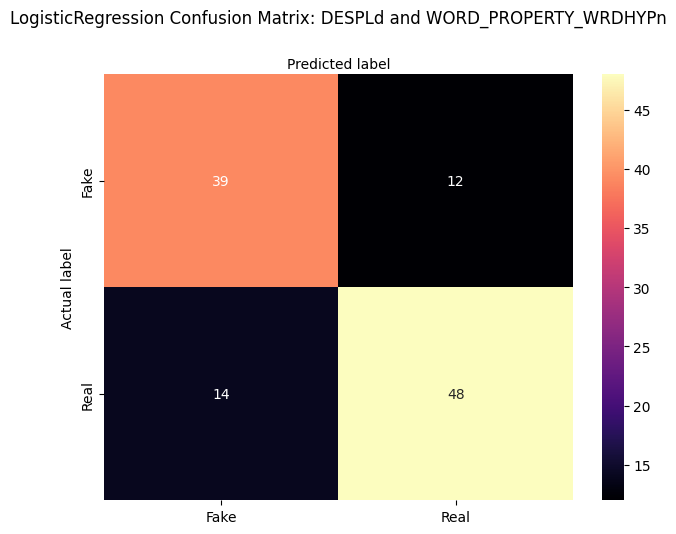

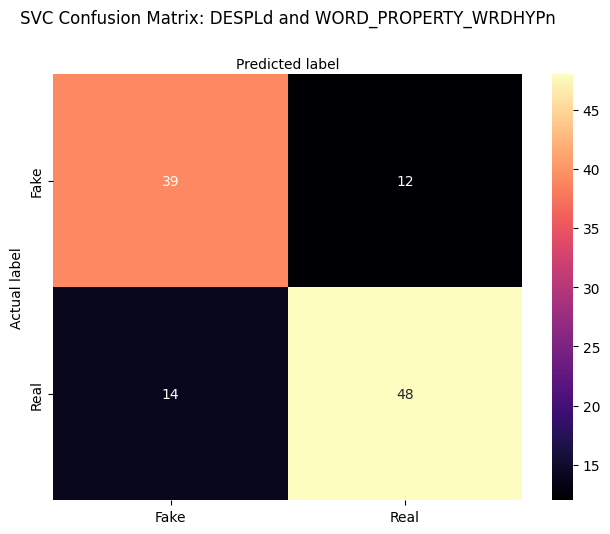

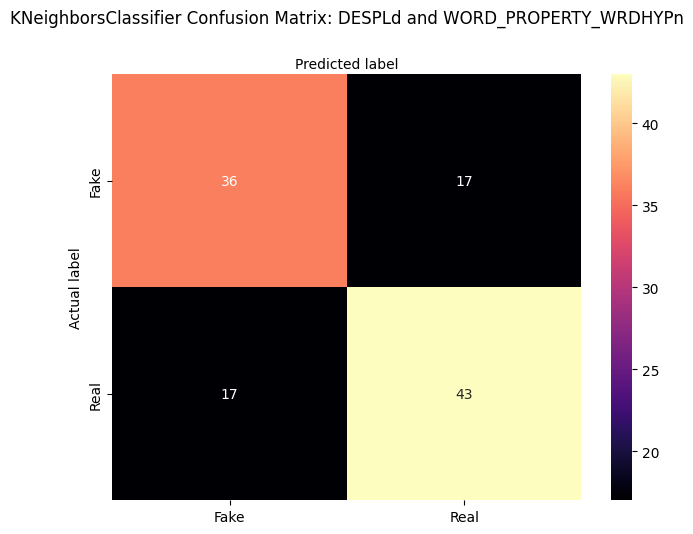

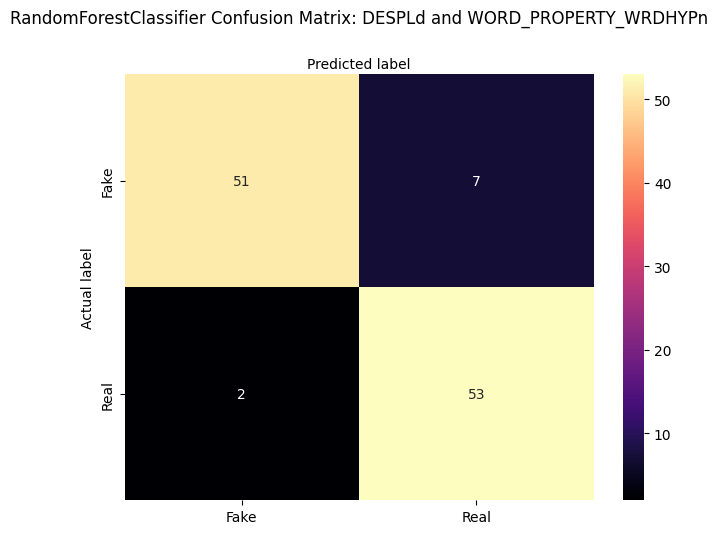

In [104]:
features = ['DESPLd',	'WORD_PROPERTY_WRDHYPn']
models_DESPLd_WORD_PROPERTY_WRDHYPn = magic(final_fts, features)

In [105]:
# pickle.dump(logistic_regression, open("lg_DESPLd_WORD_PROPERTY_WRDHYPn", "wb"))

In [106]:
models_DESPLd_WORD_PROPERTY_WRDHYPn

[{'name': 'DESPLd__WORD_PROPERTY_WRDHYPn__LogisticRegression',
  'features': ['DESPLd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'LogisticRegression',
  'accuracy': 0.7699115044247787,
  'report': '              precision    recall  f1-score   support\n\n        Fake       0.76      0.74      0.75        53\n        Real       0.77      0.80      0.79        60\n\n    accuracy                           0.77       113\n   macro avg       0.77      0.77      0.77       113\nweighted avg       0.77      0.77      0.77       113\n',
  'cv_score': array([0.71111111, 0.74444444, 0.75555556, 0.74444444, 0.78888889]),
  'mean_cv_accuracy': 0.7488888888888889,
  'confussion_matrix': array([[39, 12],
         [14, 48]])},
 {'name': 'DESPLd__WORD_PROPERTY_WRDHYPn__SVC',
  'features': ['DESPLd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'SVC',
  'accuracy': 0.7699115044247787,
  'report': '              precision    recall  f1-score   support\n\n        Fake       0.76      0.74      0.75        53\n      

DESPLd and DESWLltd

<ipython-input-96-eb9d9cbc9add>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Polarity[data.Polarity == 'Fake'] = 0
<ipython-input-96-eb9d9cbc9add>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Polarity[data.Polarity == 'TRUE'] = 1


Info: 2 features were passed at the fit step
:
DESWLltd
DESPLd

 LogisticRegression 
 

OVERALL ACCURACY LogisticRegression : 97.35 %

              precision    recall  f1-score   support

        Fake       1.00      0.94      0.97        53
        Real       0.95      1.00      0.98        60

    accuracy                           0.97       113
   macro avg       0.98      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113



CROSS VALIDATION

Accuracy LogisticRegression for each of the 5 iterations:
90.0 %
90.0 %
97.78 %
92.22 %
94.44 %

Cross validation mean accuracy for LogisticRegression: 92.89 %

-------------------------------------------------------------------------




 SVC 
 

OVERALL ACCURACY SVC : 97.35 %

              precision    recall  f1-score   support

        Fake       1.00      0.94      0.97        53
        Real       0.95      1.00      0.98        60

    accuracy                           0.97       113
   macro avg       0

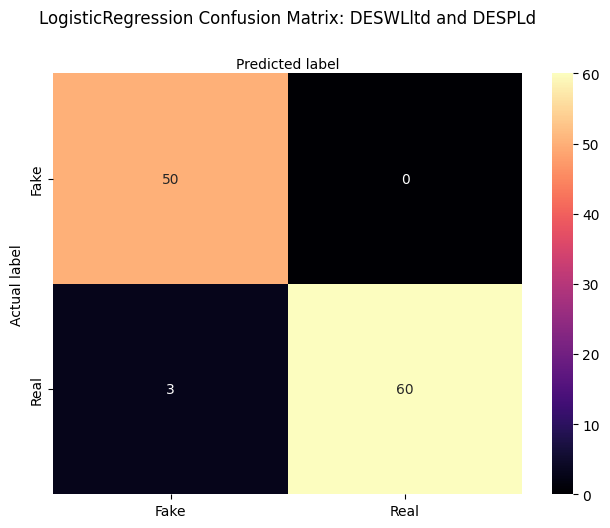

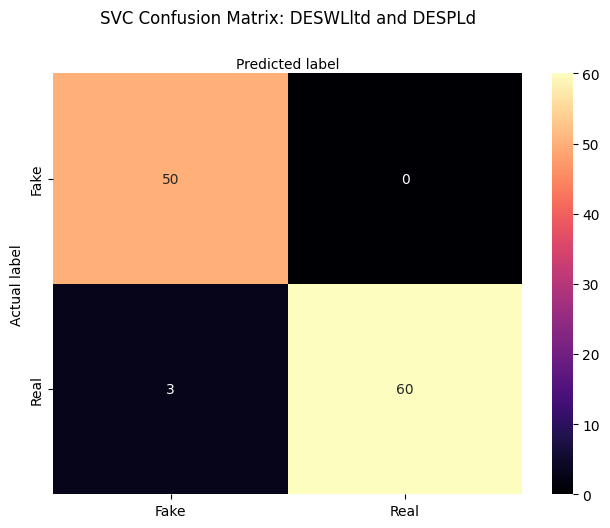

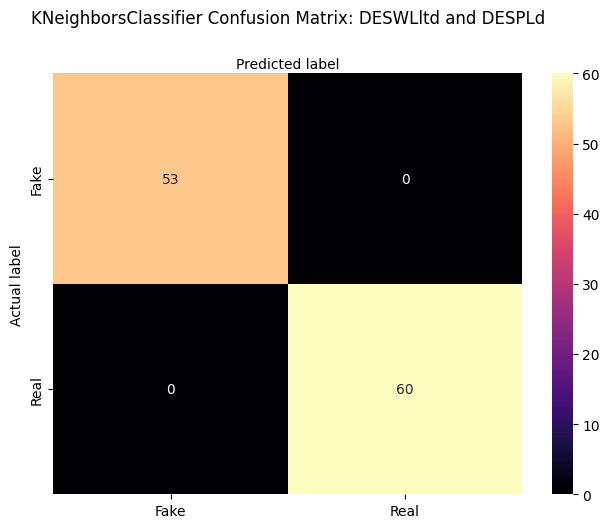

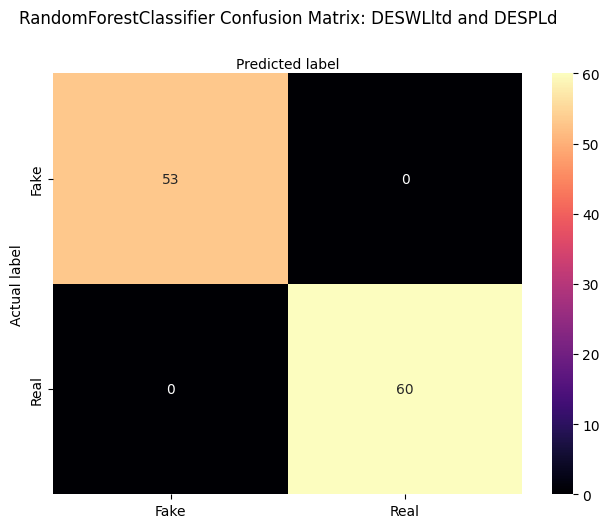

In [107]:
features = ['DESWLltd',	'DESPLd']
models_DESWLltd_DESWLltd = magic(final_fts, features)


In [108]:
# pickle.dump(logistic_regression, open("lg_DESPLd_DESWLltd", "wb"))

In [109]:
models_DESWLltd_DESWLltd

[{'name': 'DESWLltd__DESPLd__LogisticRegression',
  'features': ['DESWLltd', 'DESPLd'],
  'model': 'LogisticRegression',
  'accuracy': 0.9734513274336283,
  'report': '              precision    recall  f1-score   support\n\n        Fake       1.00      0.94      0.97        53\n        Real       0.95      1.00      0.98        60\n\n    accuracy                           0.97       113\n   macro avg       0.98      0.97      0.97       113\nweighted avg       0.97      0.97      0.97       113\n',
  'cv_score': array([0.9       , 0.9       , 0.97777778, 0.92222222, 0.94444444]),
  'mean_cv_accuracy': 0.928888888888889,
  'confussion_matrix': array([[50,  0],
         [ 3, 60]])},
 {'name': 'DESWLltd__DESPLd__SVC',
  'features': ['DESWLltd', 'DESPLd'],
  'model': 'SVC',
  'accuracy': 0.9734513274336283,
  'report': '              precision    recall  f1-score   support\n\n        Fake       1.00      0.94      0.97        53\n        Real       0.95      1.00      0.98        60\n\n  

# Logistic Regression using only our OP feature

DESWLltd

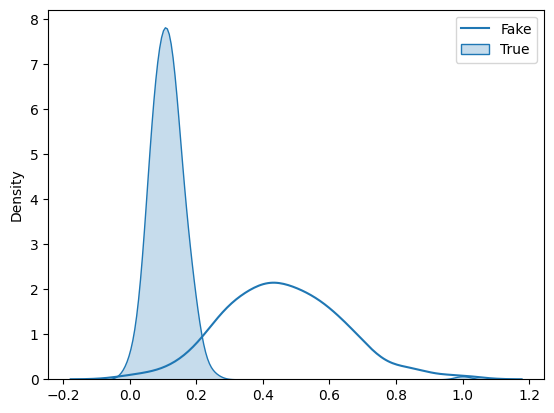




<ipython-input-96-eb9d9cbc9add>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Polarity[data.Polarity == 'Fake'] = 0
<ipython-input-96-eb9d9cbc9add>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Polarity[data.Polarity == 'TRUE'] = 1


Info: 1 features were passed at the fit step
:
DESWLltd

 LogisticRegression 
 

OVERALL ACCURACY LogisticRegression : 95.58 %

              precision    recall  f1-score   support

        Fake       1.00      0.91      0.95        53
        Real       0.92      1.00      0.96        60

    accuracy                           0.96       113
   macro avg       0.96      0.95      0.96       113
weighted avg       0.96      0.96      0.96       113



CROSS VALIDATION

Accuracy LogisticRegression for each of the 5 iterations:
87.78 %
90.0 %
98.89 %
95.56 %
94.44 %

Cross validation mean accuracy for LogisticRegression: 93.33 %

-------------------------------------------------------------------------




 SVC 
 

OVERALL ACCURACY SVC : 97.35 %

              precision    recall  f1-score   support

        Fake       1.00      0.94      0.97        53
        Real       0.95      1.00      0.98        60

    accuracy                           0.97       113
   macro avg       0.98   

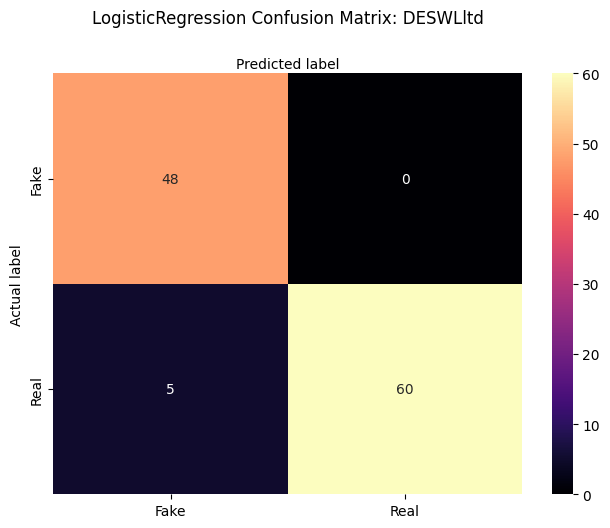

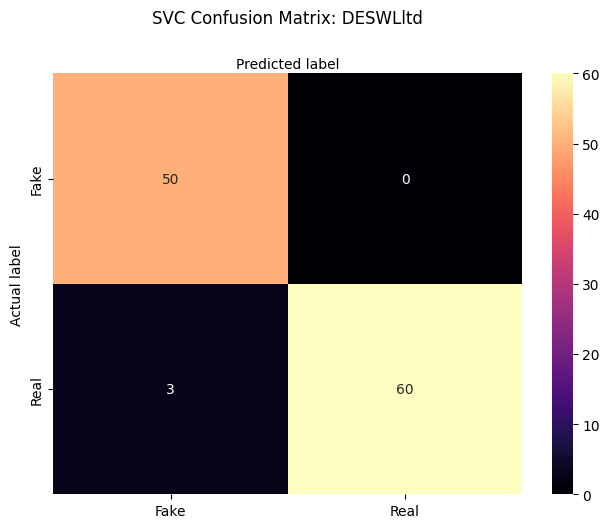

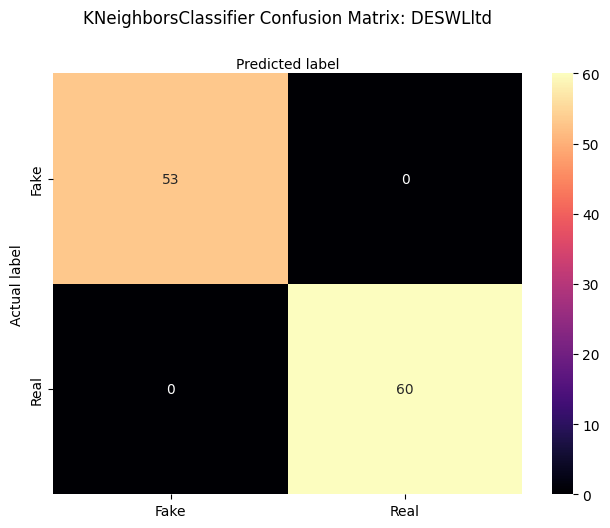

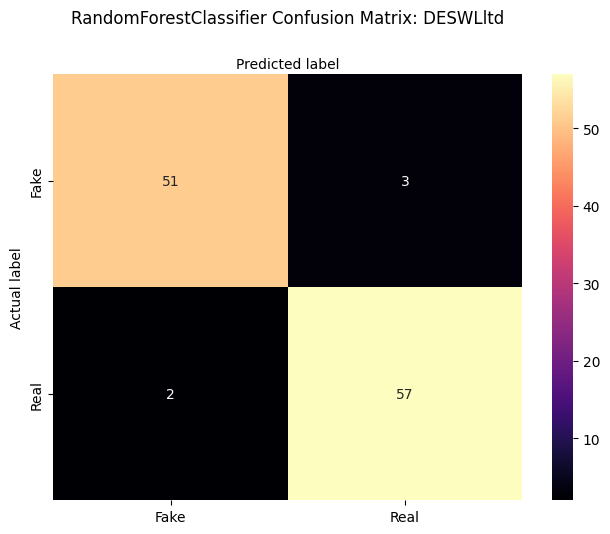

In [110]:
features = ['DESWLltd']
models_DESWLltd = magic(final_fts, features)

In [111]:
# pickle.dump(logistic_regression, open("lg_DESWLltd", "wb"))

In [112]:
models_DESWLltd

[{'name': 'DESWLltd__LogisticRegression',
  'features': ['DESWLltd'],
  'model': 'LogisticRegression',
  'accuracy': 0.9557522123893806,
  'report': '              precision    recall  f1-score   support\n\n        Fake       1.00      0.91      0.95        53\n        Real       0.92      1.00      0.96        60\n\n    accuracy                           0.96       113\n   macro avg       0.96      0.95      0.96       113\nweighted avg       0.96      0.96      0.96       113\n',
  'cv_score': array([0.87777778, 0.9       , 0.98888889, 0.95555556, 0.94444444]),
  'mean_cv_accuracy': 0.9333333333333333,
  'confussion_matrix': array([[48,  0],
         [ 5, 60]])},
 {'name': 'DESWLltd__SVC',
  'features': ['DESWLltd'],
  'model': 'SVC',
  'accuracy': 0.9734513274336283,
  'report': '              precision    recall  f1-score   support\n\n        Fake       1.00      0.94      0.97        53\n        Real       0.95      1.00      0.98        60\n\n    accuracy                         

In [113]:

'''

small crossvalidation to make sure model is stableand std bt the scores , lucky distr.

data augmentation - + at the end with the generation model, feed the model with new elements

method to input some text and see the prediction irt,
automatically add fake news text to the data


this is quant but we need qualitative

SMOTE libary for DAug

name of the file and template of the acl file - subsections things

qualitative vs quantitative studies

'''

'\n\nsmall crossvalidation to make sure model is stableand std bt the scores , lucky distr.\n\ndata augmentation - + at the end with the generation model, feed the model with new elements\n\nmethod to input some text and see the prediction irt,\nautomatically add fake news text to the data\n\n\nthis is quant but we need qualitative\n\nSMOTE libary for DAug\n\nname of the file and template of the acl file - subsections things\n\nqualitative vs quantitative studies\n\n'